In [1]:
'''
Remember to use only tensorflow (otherwise problems with keras)
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import librosa
import tensorflow.keras.backend as K
import IPython.display as ipd
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p ~/ .kaggle


In [4]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/


cp: target '.kaggle/' is not a directory


In [5]:
!chmod 600 ~/ .kaggle/kaggle.json


chmod: cannot access '.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [01:05<00:00, 21.9MB/s]
100% 1.21G/1.21G [01:05<00:00, 20.0MB/s]


In [7]:
!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

In [12]:
seed = 42
import tensorflow as tf
tf.compat.v1.set_random_seed(seed)

In [13]:
PATH = "/content/Data/genres_original"
LATENT_DIM = 2

In [14]:
'''
Classes for preprocessing:

'''

class Loader:
    def __init__(self,sample_rate, duration, mono) -> None:
        self.sample_rate = sample_rate
        self.duration = duration # only load up to this much audio (in seconds)
        self.mono = mono

    def __init__(self) -> None:
        self.sample_rate = 22050
        self.duration=10
        self.mono = True


    def load(self, file_path):
        # Load an audio file as a floating point time series.
        signal , sampling_rate = librosa.load(file_path,sr=self.sample_rate, duration=self.duration, mono = self.mono)
        return signal


class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """
    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]

        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram


class Audio_utils:
    def __init__(self) -> None:
        self.min = 0
        self.max = 1

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array

    def generate_save_path(self, file_name):
        feature_save_dir = "./Spectrograms/"
        save_path = os.path.join(feature_save_dir, file_name + ".npy")
        return save_path

    def save_feature(self, feature, file_name):
        save_path = self.generate_save_path(file_name)
        np.save(save_path, feature)

    def save_min_max_values(self):
        save_path = os.path.join("min_max/",
                                 "min_max_values.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(self.min_max_values, f)

    def store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values = {}

        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }


In [15]:
l = Loader()
sample = l.load(file_path="/content/Data/genres_original/blues/blues.00000.wav")

In [16]:
ipd.Audio(sample,rate=22050)

In [18]:
# Define frame size and hop length
frame_size = 2048  # Number of samples per frame
hop_length = 512   # Number of samples between frames
sp = LogSpectrogramExtractor(frame_size=frame_size,hop_length=hop_length)
s = sp.extract(sample)

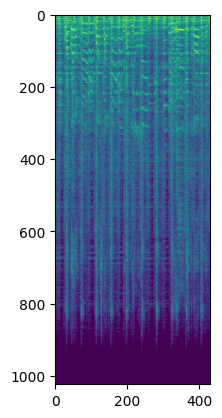

In [19]:
u = Audio_utils()
s1 = u.normalise(s)
plt.imshow(s1)
plt.show()

Some notes about Spectograms:
- They are generated using the Fourier Transform;
- Moreover using the Short-Fourier Transform since we define a frame(window) and compute the fourier transform on each segment;
- In this way, the Spectogram encoded also the information about how the frequency components change over time

Which are the output of the Fourier transform?
- a magnitude (expressing the similarity between the signal/segment and a sinuosoid with a given frequency)
- basically the obtained magnitudes for each frame are grouped and they generated a frequency vector

# Let's process the data

In [20]:
import os

audio_loader = Loader()

# Define frame size and hop length
frame_size = 1024 # Number of samples per frame
hop_length = 256   # Number of samples between frames
audio_spectr = LogSpectrogramExtractor(frame_size=frame_size,hop_length=hop_length)

audio_utils = Audio_utils()
s1 = u.normalise(s)

# Saving the features
for root, _, files in os.walk(PATH+"/blues"):
    for file in files:
        file_path = os.path.join(root, file)
        signal = audio_loader.load(file_path=file_path)
        spect = audio_spectr.extract(signal)
        norm_spect = audio_utils.normalise(spect)
        audio_utils.save_feature(norm_spect,file_name=file)
        audio_utils.store_min_max_value(file,  spect.min(),  spect.max())
        audio_utils.save_min_max_values()


In [21]:
norm_spect.shape

(512, 862)

Let's train the model

In [22]:
spectrograms_path = "/content/Spectrograms"
x_train = []
for root, _, file_names in os.walk(spectrograms_path):
    for file_name in file_names:
        file_path = os.path.join(root, file_name)
        spectrogram = np.load(file_path) # (512, 862), a simple matrix
        x_train.append(spectrogram) # (100, 512, 862)

In [23]:
x_train = np.array(x_train)
x_train = x_train[..., np.newaxis] # -> (100, 512, 862, 1)

In [24]:
# Verify the shape and type of x_train
print(type(x_train))  # Should print <class 'numpy.ndarray'>
print(x_train.shape)  # Should print (N, 1024, 431,1)

<class 'numpy.ndarray'>
(100, 512, 862, 1)


now we are ready to train a model, since we have a numpy array with each element a matrix of 1 dimension

# Model

we use a VAE model.

- Features:
    - Encoder
        - Given an input, it outputs a set of parameters defining a posterior distribution ( the mean and the log variance)
        - Basically, it samples from this distro and then pass the new vector to the decoder.
        - Yet, there is the need of a constraint here. Otherwise, the latent space can be without meaning if is too sparse. This is achieved by adding a regularization term to the loss function, encouraging the latent space to follow a standard normal distribution.
    - Decoder
        - This takes the sample and outputs the final output.
        - Basically, it defines a conditional distro which takes the latent sample as input and outputs the final result.

    - Reparameterization:
        - How to backpropagate a sampling operation (Non- differentiability operation)?
            - using reparameterization: z = mean + variance * Eps (Eps is from a standard normal)
            -  z is now a deterministic operation of the encoder's outputs and some noise;
            -  Then we can backpropagate on the mean and the variance
        - the core idea is: instead of just sampling from the gaussian distro, the encoder outputs the mean and the variance of it. In this way using the reparameterization trick(scaling and shifting from a standard normal) we can backpropagate obtaining a sample from the original gaussian distro.

    - Basically, in VAE the goal is to learnt a latent space that approximate a standard normal distro (in this way we have sth continuous) and that minimize the reconstruction loss.
        - The KV divergence set the posterior (normal) toward the prior (standard normal)
        - the reconstruction loss make it better

In [25]:
from VAE import VAE
from tensorflow.python.framework.ops import disable_eager_execution
model = VAE((512, 862,1),2)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 512, 862, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 862, 32)         320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 431, 64)         18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 431, 64)         36928     ['conv2d_1[0][0]']            
                                                                                            

In [26]:
x_train.shape

(100, 512, 862, 1)

In [95]:
model.compile()
model.train(x_train,8,10)

Input shape of x_train: (100, 512, 862, 1)
Training the model...
Epoch 1/10
13/13 [==============================] - 7s 345ms/step - loss: 0.0446
Epoch 2/10
13/13 [==============================] - 5s 345ms/step - loss: 0.0413
Epoch 3/10
13/13 [==============================] - 5s 346ms/step - loss: 0.0395
Epoch 4/10
13/13 [==============================] - 5s 347ms/step - loss: 0.0383
Epoch 5/10
13/13 [==============================] - 4s 345ms/step - loss: 0.0369
Epoch 6/10
13/13 [==============================] - 4s 345ms/step - loss: 0.0354
Epoch 7/10
13/13 [==============================] - 4s 345ms/step - loss: 0.0342
Epoch 8/10
13/13 [==============================] - 4s 344ms/step - loss: 0.0329
Epoch 9/10
13/13 [==============================] - 4s 343ms/step - loss: 0.0317
Epoch 10/10
13/13 [==============================] - 4s 342ms/step - loss: 0.0307
Training completed.


In [96]:
import numpy as np
import librosa

class Sound:
    def __init__(self, num_samples, latent_dim, model) -> None:
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.decoder = model.decoder

    def predict(self):
        latent_points = np.random.normal(size=(self.num_samples, self.latent_dim))
        preds = self.decoder.predict(latent_points)
        print(preds.shape)
        preds = preds.reshape(preds.shape[1], preds.shape[2])
        print(preds.shape)
        sounds = self.spectrogram_to_sound(preds)
        return sounds

    def spectrogram_to_sound(self, spec):

        hop_length = 256  # FFT window size (equal to frame size)
        win_length = 862  # Window size
        window = 'hann'  # Window type

        reconstructed_audio_signal = librosa.istft(spec, hop_length=hop_length, win_length=win_length, window=window)

        return reconstructed_audio_signal


In [97]:
s = Sound(1,2,model)
sound = s.predict()
len(sound)

1/1 [==============================] - 0s 21ms/step
(1, 512, 862, 1)
(512, 862)


220416

In [98]:
sound.shape

(220416,)

In [105]:
from IPython.display import Audio
Audio(sound,rate=50)